# How to call DALL·E-3 with configuration

DALL·E-3 model exposes certain request [parameters](https://platform.openai.com/docs/api-reference/images/create)—such as `quality`, `size`, and `style`—that are missing from the [DIAL chat completion request](https://dialx.ai/dial_api#/paths/~1openai~1deployments~1%7BDeployment%20Name%7D~1chat~1completions/post).

However, DIAL supports passing these model-specific parameters through the `custom_fields.configuration` field in the chat completion request.

This notebook demonstrates how to call the DALL·E-3 model with those additional parameters using DIAL’s configuration mechanics.

https://github.com/epam/ai-dial/blob/main/dial-cookbook/examples/how_to_call_dalle_3_with_configuration.ipynb


## Setup

Install the necessary dependencies and import the libraries we are going to use.

In [ ]:
!pip install -q openai==1.43.0
!pip install -q httpx==0.27.2
!pip install -q pillow==11.1.0
!pip install -q python-dotenv==1.0.1

In [49]:
import openai # OpenAI Python library to make API calls to DIAL Chat Completion API
import httpx # HTTP client library to make API calls to DIAL File API
from PIL import Image  # used to print images
from dotenv import load_dotenv # used to pick up DIAL credential from the local .env file if it exists

load_dotenv(override=True)

True

Set the DIAL URL and your API key either by setting them in the local `.env` file or by setting the variables in the notebook explicitly.

In [50]:
import os

dial_url = os.environ.get("DIAL_URL") or "YOUR_DIAL_URL"
dial_api_key = os.environ.get("DIAL_API_KEY") or "YOUR_DIAL_API_KEY"
dial_deployment = os.environ.get("DALLE3_DEPLOYMENT_NAME") or "YOUR_DALLE3_DEPLOYMENT_NAME"

Configure HTTP client to call the DIAL API:

In [51]:
http_client = httpx.Client(base_url=dial_url, headers={"api-key": dial_api_key})

## Listing metadata

First of all, we need to make sure that the given deployment does actually exist and is available for us to use.

This could be done by inspecting the [listing information](https://epam-rail.com/dial_api#tag/Deployment-listing/operation/getModel) for this deployment:


In [52]:
listing_response = http_client.get(f"/openai/deployments/{dial_deployment}")
listing_response.raise_for_status()
deployment_metadata = listing_response.json()
print(deployment_metadata)

{'id': 'dall-e-3', 'model': 'dall-e-3', 'display_name': 'DALL-E 3', 'icon_url': 'gpt3.svg', 'description': 'DALL-E is a machine-learning model developed by OpenAI. It is designed to produce images from language descriptions, a process known as text-to-image descriptions or prompts.\n\nThe system can generate realistic images just from a description of the scene. DALL-E is a neural network algorithm that creates accurate pictures from short phrases provided by the user. It comprehends language through textual descriptions and from “learning” information provided in its datasets by users and developers.', 'reference': 'dall-e-3', 'owner': 'organization-owner', 'object': 'model', 'status': 'succeeded', 'created_at': 1672534800, 'updated_at': 1672534800, 'features': {'rate': False, 'tokenize': False, 'truncate_prompt': False, 'configuration': True, 'system_prompt': False, 'tools': False, 'seed': False, 'url_attachments': False, 'folder_attachments': False, 'allow_resume': True, 'accessible

> **Troubleshooting**
>
> The request fails when either of the `dial_*` variables is not set correctly.
>
> 1. Incorrect DIAL URL leads in `ConnectError`
>
> 2. Incorrect API key leads to `401 Unauthorized error`
>
> 3. Non existing deployment name results in `404 Not Found error`
>
> In the last case, you may request the [whole listing](https://epam-rail.com/dial_api#tag/Deployment-listing/operation/getModels) and pick the correct deployment name for DALL·E-3 in your DIAL instance:
>
> ```python
> all_models = http_client.get("/openai/deployments").json()
> ```

What is of interest to us is the features supported by this model.
The feature flags are stored in the `features` field of the deployment listing.
The flag `features.configuration` indicates that the model is configurable.

In [53]:
features = deployment_metadata['features']
print(f"Deployment features")
print(features)
is_configurable = features['configuration']
print(f"Deployment is configurable: {is_configurable}")
assert is_configurable, "Deployment is not configurable"

Deployment features
{'rate': False, 'tokenize': False, 'truncate_prompt': False, 'configuration': True, 'system_prompt': False, 'tools': False, 'seed': False, 'url_attachments': False, 'folder_attachments': False, 'allow_resume': True, 'accessible_by_per_request_key': True, 'content_parts': False, 'temperature': True, 'addons': True, 'cache': False, 'auto_caching': False}
Deployment is configurable: True


## Configuration schema

A deployment is configurable when it exposes the configuration endpoint: `v1/models/{model_name}/configuration`.
This endpoint returns [JSON Schema](https://json-schema.org/) for the configuration object that can be passed to the model in chat completion requests.

In [54]:
configuration_schema_response = http_client.get(f"/v1/deployments/{dial_deployment}/configuration")
configuration_schema_response.raise_for_status()
configuration_schema = configuration_schema_response.json()
print(configuration_schema)

{'title': 'Dalle3Config', 'type': 'object', 'properties': {'quality': {'title': 'Quality', 'description': 'The quality of the image that will be generated.', 'anyOf': [{'enum': ['standard', 'hd'], 'type': 'string'}, {'type': 'string'}]}, 'size': {'title': 'Size', 'description': 'The size of the generated images.', 'anyOf': [{'enum': ['1024x1024', '1792x1024', '1024x1792'], 'type': 'string'}, {'type': 'string'}]}, 'style': {'title': 'Style', 'description': 'The style of the generated images.', 'anyOf': [{'enum': ['vivid', 'natural'], 'type': 'string'}, {'type': 'string'}]}}}


The schema says that the configuration may contain any of the following optional fields:
- `quality` - the quality of the generated image (`standard` or `hd`)
- `size` - the size of the generated image (one of `1024x1024`, `1792x1024`, `1024x1792`)
- `style` - the style of the generated image (`vivid` or `natural`)

## Image generation

The DIAL deployment could be called via [OpenAI Python SDK](https://pypi.org/project/openai/).


In [55]:
openai_client = openai.AzureOpenAI(
    azure_endpoint=dial_url,
    azure_deployment=dial_deployment,
    api_key=dial_api_key,
    api_version="2023-12-01-preview",
)

Let's call the model with the configuration provided in the `custom_fields.configuration` field of the chat completion request.
The first user message contains the prompt for the DALL·E-3 model.

In [56]:
dalle3_config = {
    "quality": "hd",
    "size": "1792x1024",
    "style": "vivid"
}

chat_completion = openai_client.chat.completions.create(
    messages=[{"role": "user", "content": "cats"}],
    model=dial_deployment,
    extra_body={"custom_fields": {"configuration": dalle3_config}}
)
print(chat_completion)

ChatCompletion(id='chatcmpl-96ab4f47-4ae3-4227-965a-e236b3ca46a1', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', function_call=None, tool_calls=None, custom_content={'attachments': [{'title': 'Revised prompt', 'data': 'A warm, sunny landscape with several cats. Some cats are napping peacefully under the shade of a large tree, while others are playfully chasing butterflies. A few cats are curiously exploring, their tails flicking with interest. Their fur has varied colors like orange, black, white, and grey. A shallow stream runs through the middle of the scene, and a Mama cat is teaching her kittens how to drink from it.'}, {'title': 'Image', 'type': 'image/png', 'url': 'files/7vUVRwvWDh53WKUnmGV21ndnvsnpgZT9urEnPxnepjnF/appdata/dall-e-3/images/e644fea57d202b724178f1980592c50d56f77560979854b99a1d724afe958424.png'}]}))], created=1742401425, model=None, object='chat.completion', service_tier=None, s

> **Note**
>
> The configuration value that doesn't follow the schema *(such as `{"quality": 42}`)* will lead to an invalid request error.

The chat completion response contains two attachments: one with the revised prompt and the other with the generated image.

The revised prompt is an elaborated version of the original prompt that was generated by the DALL·E-3 model before the image generation.

In [57]:
message = chat_completion.choices[0].message
attachments = message.custom_content["attachments"]
revised_prompt = attachments[0]["data"]
print(f"Revised prompt: {revised_prompt}")

Revised prompt: A warm, sunny landscape with several cats. Some cats are napping peacefully under the shade of a large tree, while others are playfully chasing butterflies. A few cats are curiously exploring, their tails flicking with interest. Their fur has varied colors like orange, black, white, and grey. A shallow stream runs through the middle of the scene, and a Mama cat is teaching her kittens how to drink from it.


The second attachment contains a link to the DIAL file storage where the generated image is stored.
It could be accessed via the [DIAL File API](https://epam-rail.com/dial_api#tag/Files/operation/downloadFile):

In [58]:
image_url = attachments[1]["url"]
print(f"Image URL: {image_url}")

Image URL: files/7vUVRwvWDh53WKUnmGV21ndnvsnpgZT9urEnPxnepjnF/appdata/dall-e-3/images/e644fea57d202b724178f1980592c50d56f77560979854b99a1d724afe958424.png


In [59]:
# set a directory to save DALL·E-3 images to
image_dir_name = "images"
image_dir = os.path.join(os.curdir, image_dir_name)
image_filepath = os.path.join(image_dir, "generated_image.png")

os.makedirs(image_dir, exist_ok=True)

file = http_client.get(f"v1/{image_url}")

# save the image to the image directory
with open(image_filepath, "wb") as image_file:
    image_file.write(file.content)
print(f"Image was saved to {image_filepath}")

Image was saved to ./images/generated_image.png


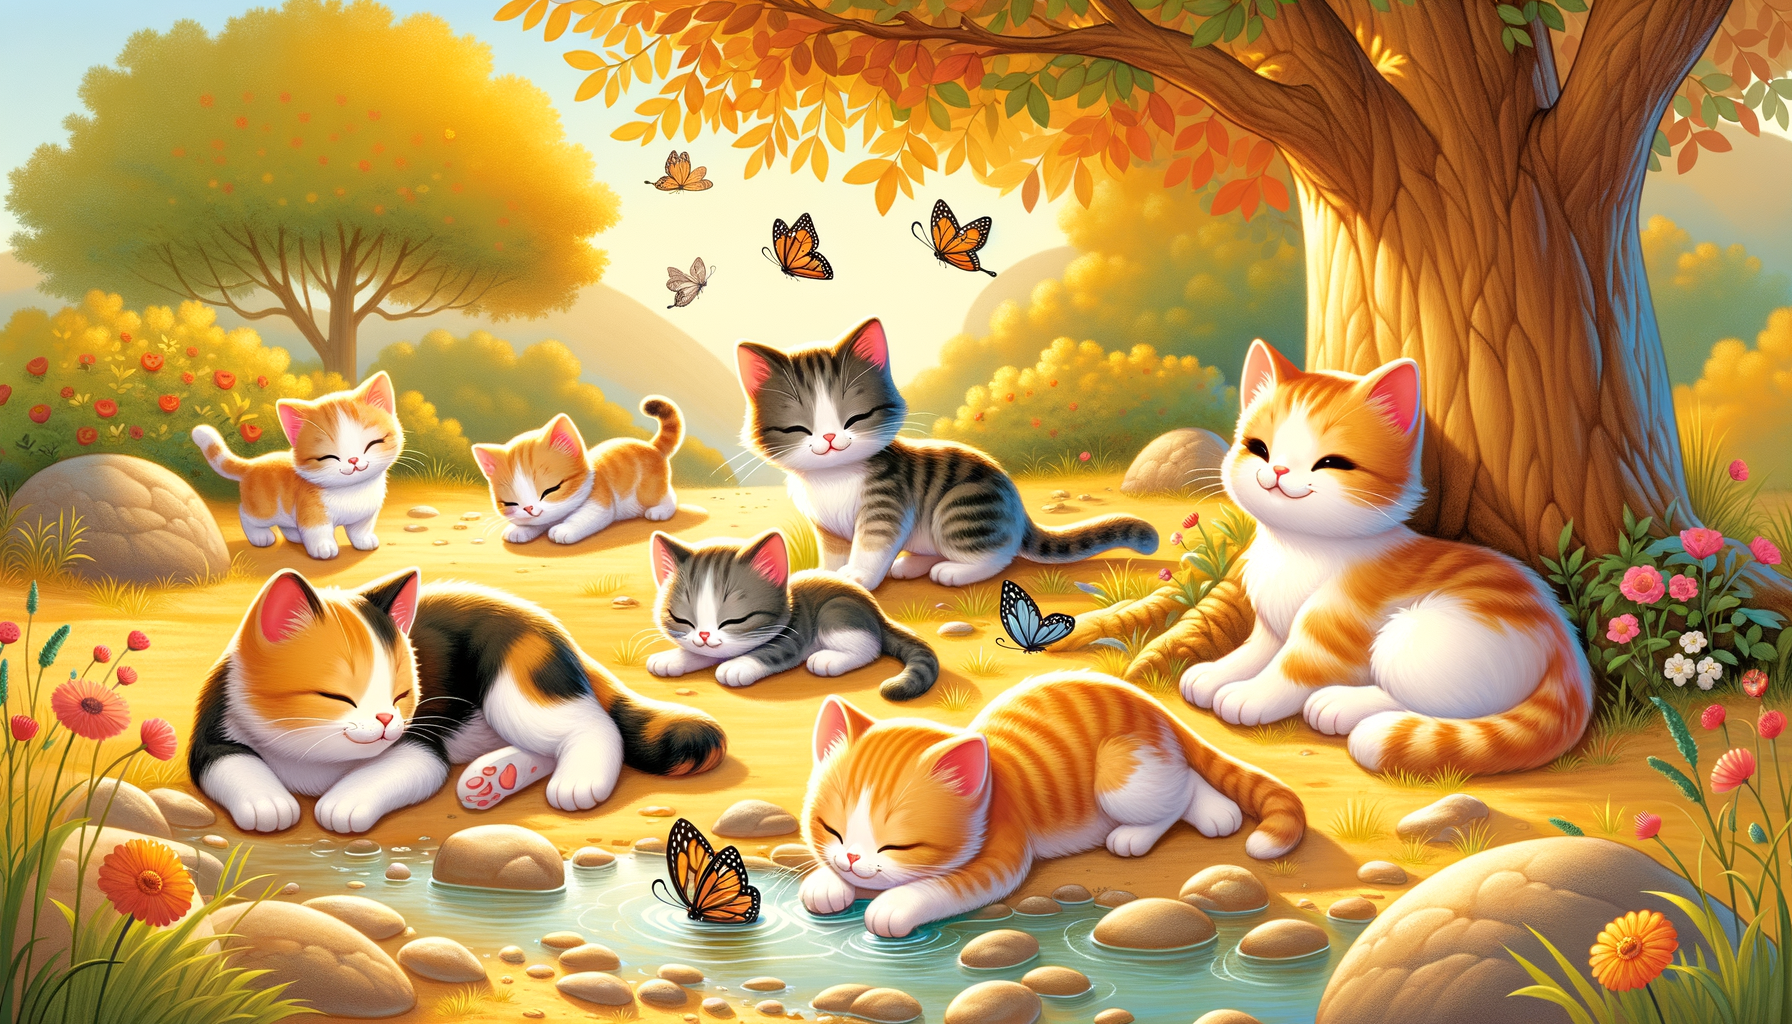

In [60]:
display(Image.open(image_filepath))